In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from datetime import datetime
import matplotlib.pyplot as plt

# Load the entire dataset
data = pd.read_csv('Processed/merged_clean.csv')

def list_values(series):
    return list(series.unique())

data = data.groupby('date').agg({
    'total_sales': 'sum', 
    'dcoilwtico': 'median',
    'transferred': list_values,
    'type': list_values
}).reset_index()

display(data)

C:\Users\Cursist\AppData\Local\Temp\ipykernel_15696\224230519.py:11: DtypeWarning:

Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.



date    total_sales  dcoilwtico           transferred  \
0     2013-01-01     281.384690         NaN  [Restricted Holiday]   
1     2013-01-02   61027.219131       93.14                 [nan]   
2     2013-01-03   46408.703473       92.97                 [nan]   
3     2013-01-04   41268.117176       93.12                 [nan]   
4     2013-01-05   62470.050970         NaN                 [nan]   
...          ...            ...         ...                   ...   
1679  2017-08-11  134081.776852       48.81                 [nan]   
1680  2017-08-12   92830.604442         NaN                 [nan]   
1681  2017-08-13  105941.589095         NaN                 [nan]   
1682  2017-08-14  116687.542837       47.59                 [nan]   
1683  2017-08-15  181305.529628       47.57    [Gazetted Holiday]   

                 type  
0                 [D]  
1     [D, B, C, E, A]  
2     [D, B, C, E, A]  
3     [D, B, C, E, A]  
4     [D, B, C, E, A]  
...               ...  
1679  [D, B, C, E, A]  
1680  [D, B, C, E, A]  
1681  [D, B, C, E, A]  
1682  [D, B, C, E, A]  
1683  [D, B, C, E, A]  

[1684 rows x 5 columns]

In [74]:
from prophet import Prophet # https://facebook.github.io/prophet/docs/quick_start.html#python-api
df = data

# Prepare the data for Prophet
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total_sales']

last_date = df['ds'].iloc[-1]

# Initialize Prophet model
m = Prophet()
m_h = Prophet()

m_h.add_country_holidays(country_name='IN')

# Fit the model
m.fit(df)
m_h.fit(df)

# Make a dataframe for future dates
future_dates = m.make_future_dataframe(periods=356)  # Predicting next 30 days
future_dates_h = m_h.make_future_dataframe(periods=356)  # Predicting next 30 days

# Make predictions
forecast = m.predict(future_dates)
forecast_h = m_h.predict(future_dates_h)


C:\Users\Cursist\AppData\Roaming\Python\Python311\site-packages\holidays\countries\india.py:99: Warning:

Diwali and Holi holidays available from 2001 to 2030 only

14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing


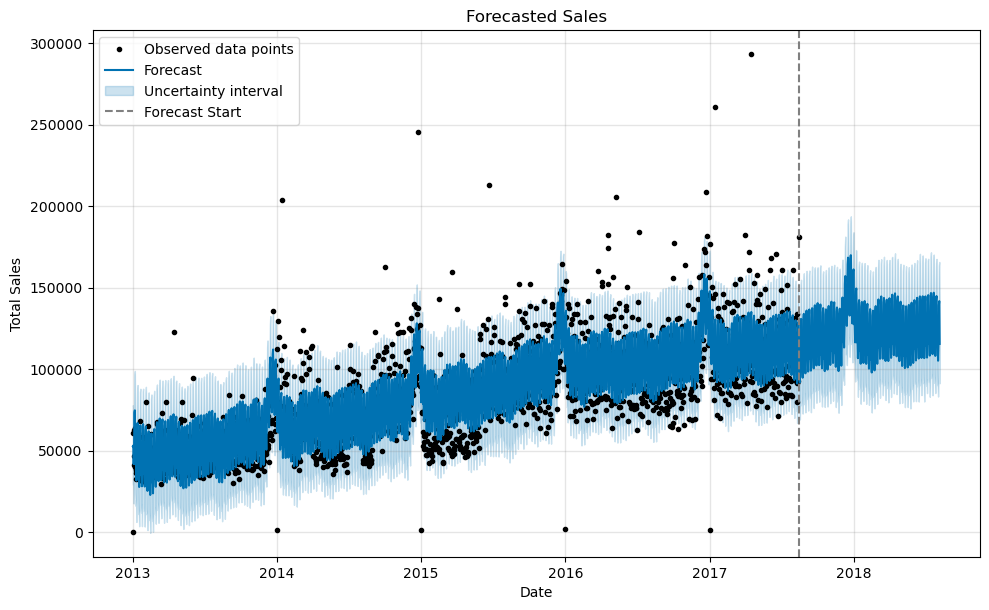

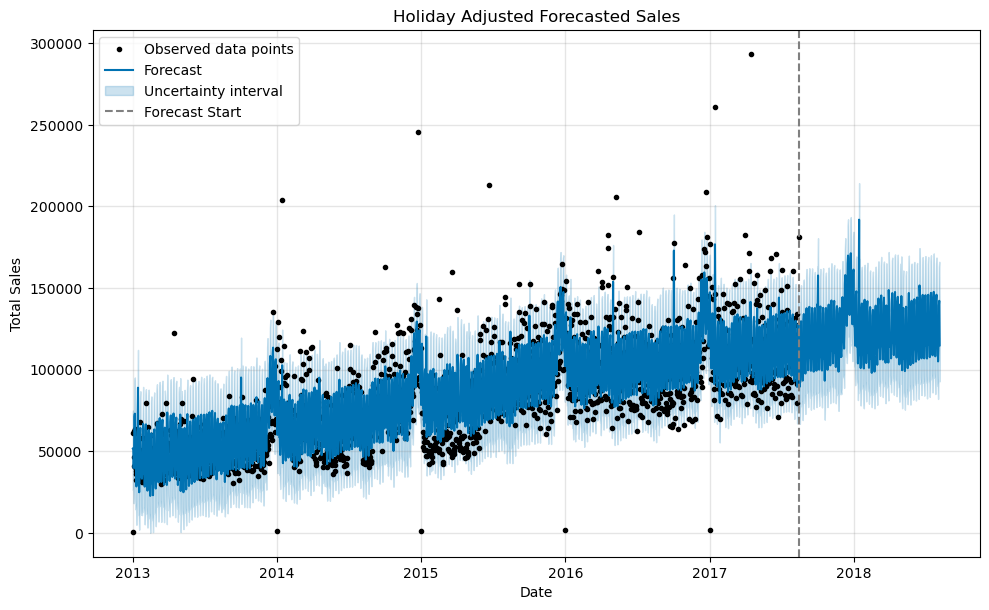

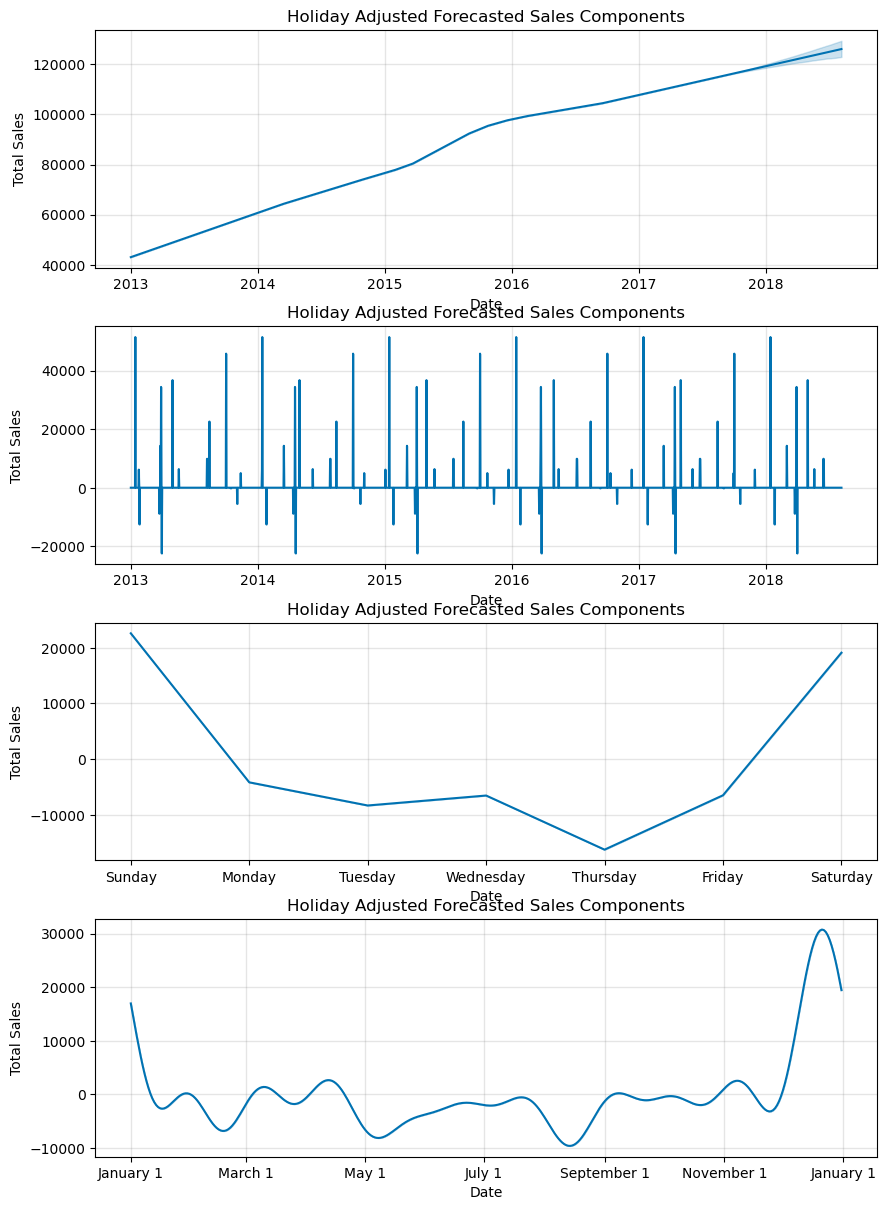

In [75]:
import matplotlib.pyplot as plt

# Plot the forecast
fig = m.plot(forecast)
figh = m_h.plot(forecast_h)
figch = m_h.plot_components(forecast_h)


# Plot a vertical line indicating where the forecast starts
forecast_start_date = last_date
for ax in fig.axes:
    ax.axvline(x=forecast_start_date, color='gray', linestyle='--', label='Forecast Start')
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    ax.set_title('Forecasted Sales')
    ax.legend()

for ax in figh.axes:
    ax.axvline(x=forecast_start_date, color='gray', linestyle='--', label='Forecast Start')
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    ax.set_title('Holiday Adjusted Forecasted Sales')
    ax.legend()


for ax in figch.axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    ax.set_title('Holiday Adjusted Forecasted Sales Components')


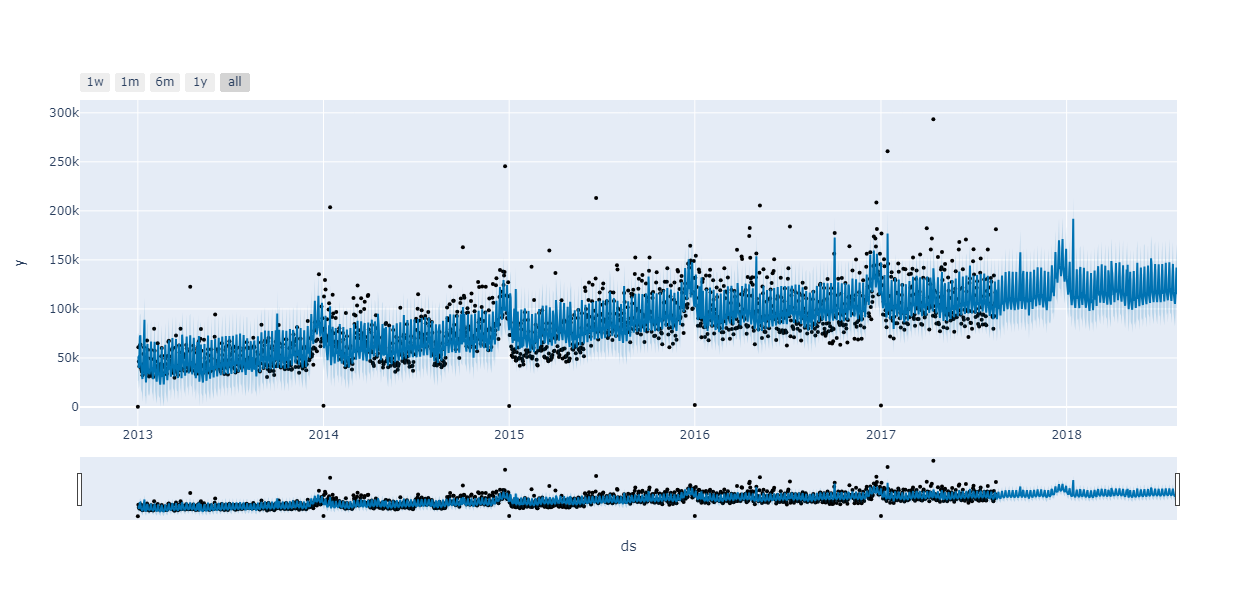

In [76]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m_h, forecast_h)


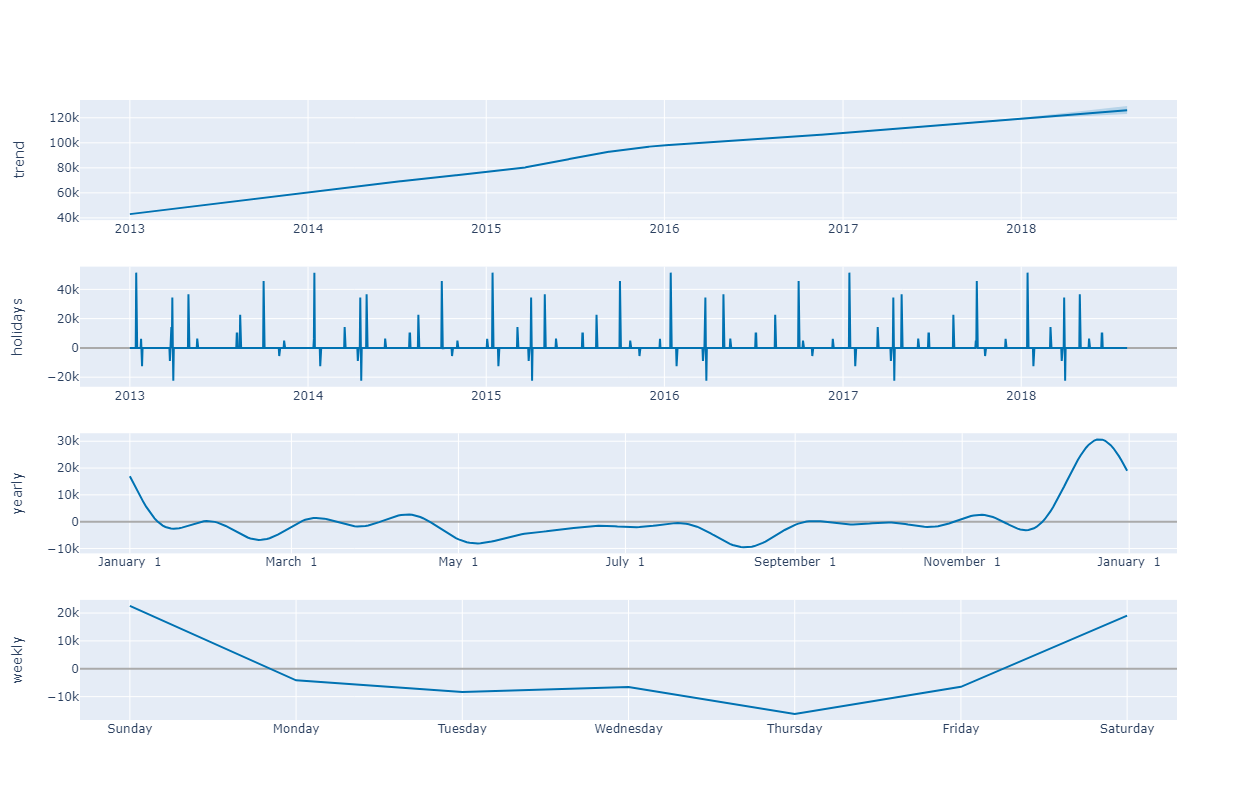

In [77]:
plot_components_plotly(m_h, forecast_h)

## Not every holiday is covered

14:55:34 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Ambedkar Jayanti', 'Ambedkar Jayanti_lower', 'Ambedkar Jayanti_upper',
       'Bakr Id/Eid ul-Adha',
       ...
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object', length=229)


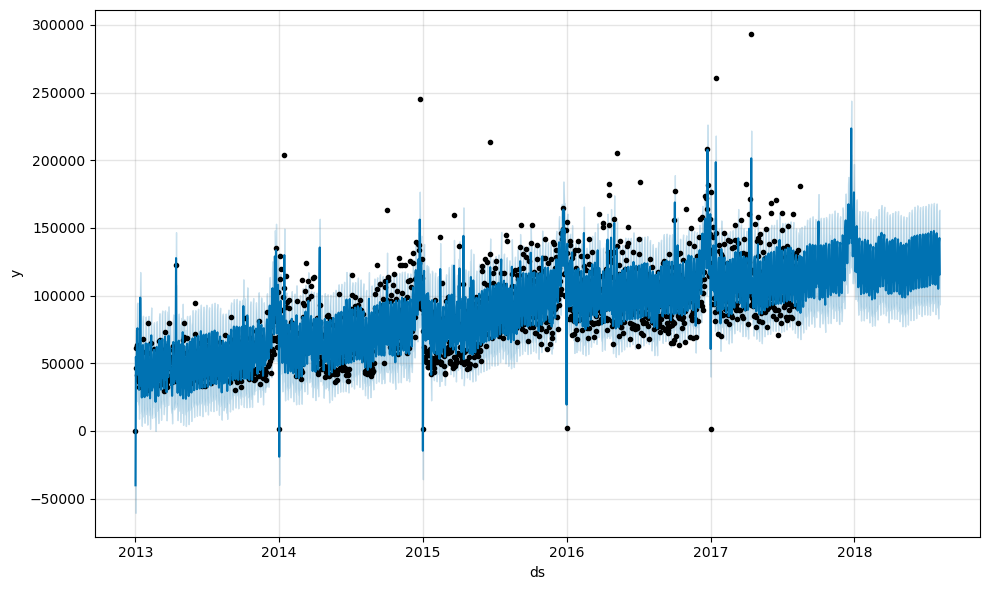

In [78]:

df = data

# Prepare the data for Prophet
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total_sales']

last_date = df['ds'].iloc[-1]

df_holidays = pd.read_csv('processed/holidays_events(india)_clean2.csv')[['date','description']]
df_holidays.rename(columns={'date': 'ds', 'description':'holiday'}, inplace=True)
model = Prophet(holidays=df_holidays)
model.fit(df)

# Make a dataframe for future dates
future_dates = model.make_future_dataframe(periods=356)  # Predicting next 30 days


# Make predictions
forecast = model.predict(future_dates)
fig = m.plot(forecast)
print(forecast.columns)

14:55:36 - cmdstanpy - INFO - Chain [1] start processing
14:55:37 - cmdstanpy - INFO - Chain [1] done processing


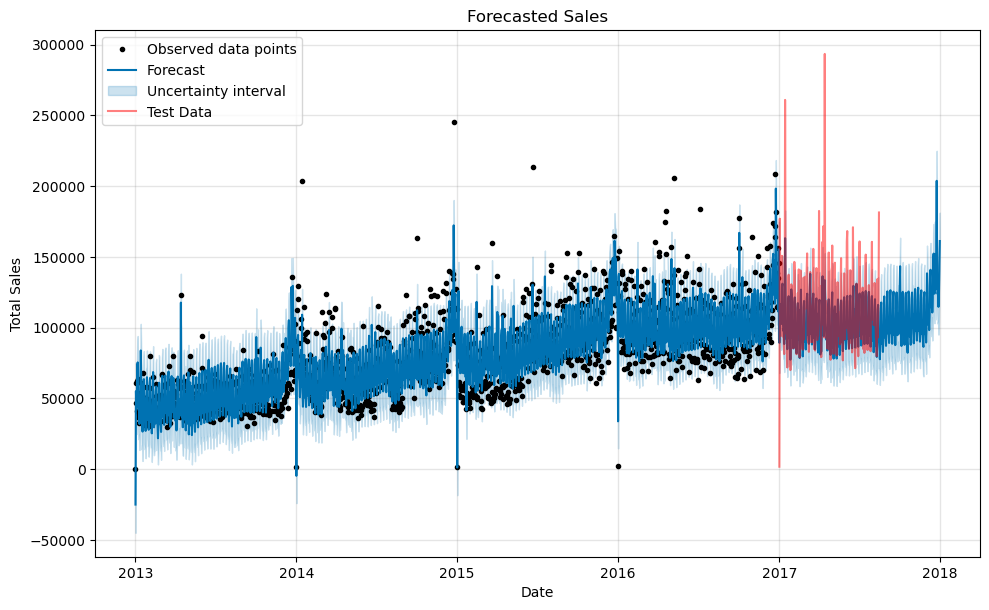

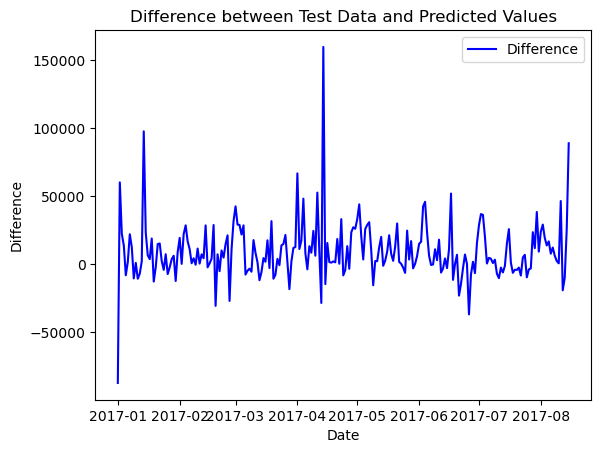

In [79]:
import pandas as pd
from prophet import Prophet

# Assuming your DataFrame is named df
# Splitting the data based on '2017-01-01'
train_df = df[df['ds'] < '2017-01-01']
test_df = df[df['ds'] >= '2017-01-01']

# Create and fit the model using training data
model = Prophet(holidays=df_holidays)
model.fit(train_df)

# Make predictions for future dates
future_dates = model.make_future_dataframe(periods=365)  # Predicting next 365 days
forecast = model.predict(future_dates)

# Plotting the forecast, training data, and testing data
fig = model.plot(forecast)

# Plot the test data
plt.plot(test_df['ds'], test_df['y'], color='red', label='Test Data', alpha=0.5)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Forecasted Sales')

# Add legend
plt.legend()

# Show plot
plt.show()

# Calculate the difference between test data and predicted values
test_predicted_diff = test_df['y'] - forecast.loc[forecast['ds'].isin(test_df['ds']), 'yhat']

# Plot the difference on a new figure
plt.figure()
plt.plot(test_df['ds'], test_predicted_diff, color='blue', label='Difference')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Difference between Test Data and Predicted Values')
plt.legend()
plt.show()

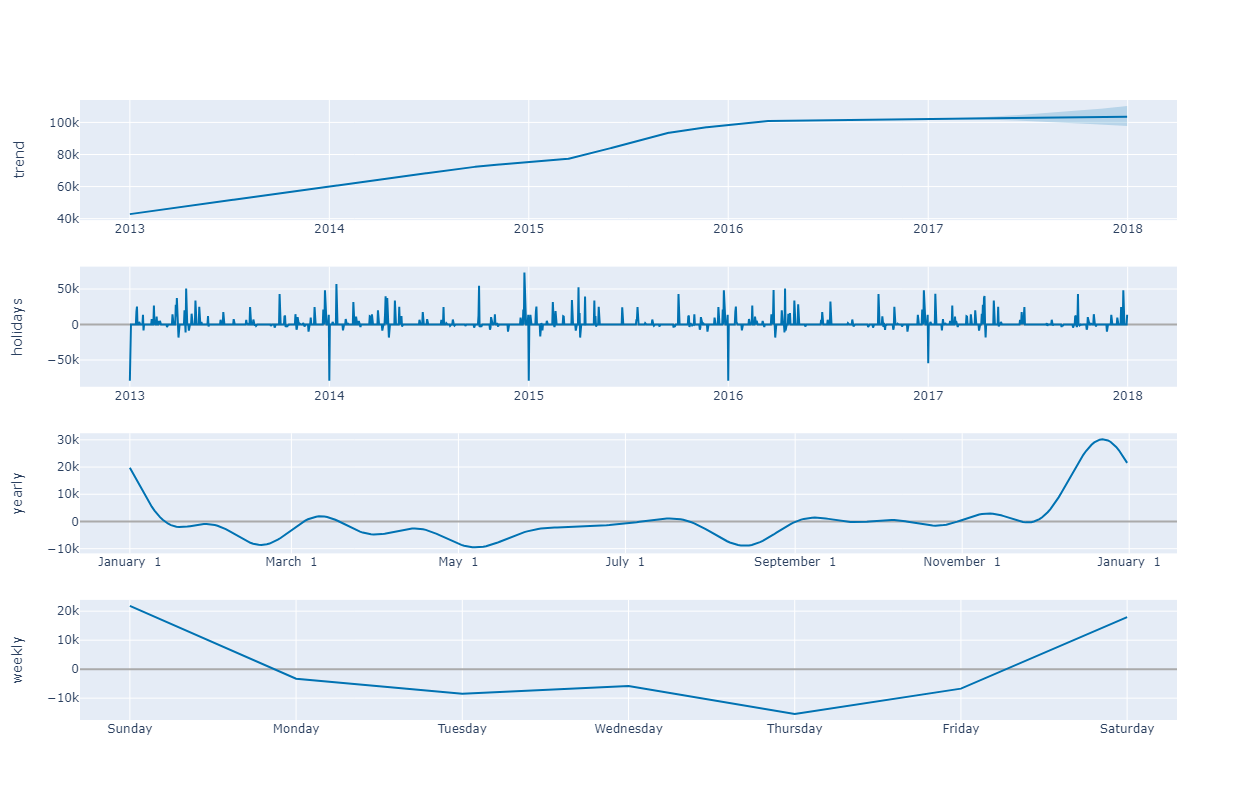

In [80]:
plot_components_plotly(model, forecast)

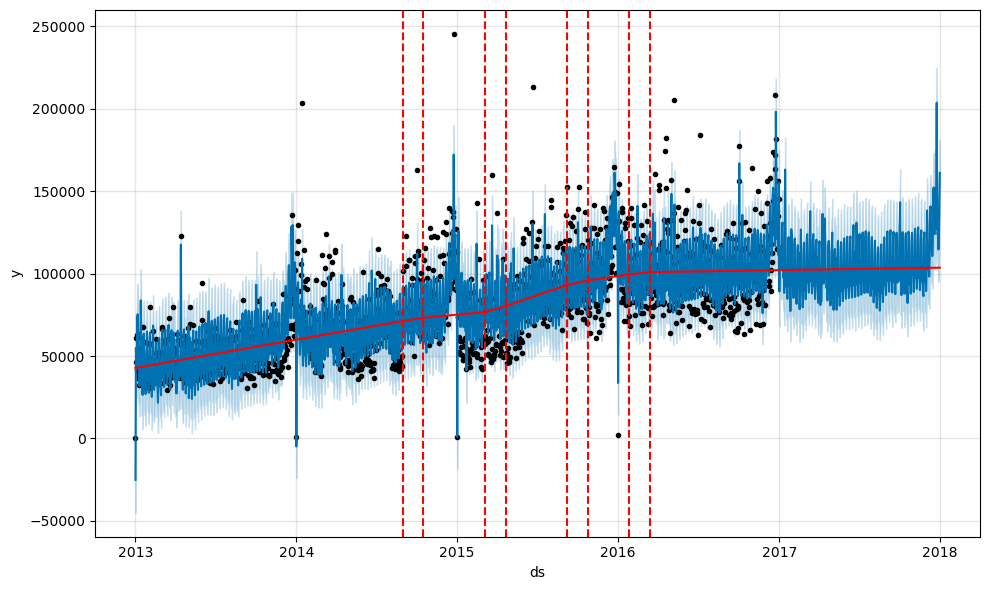

In [81]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

         date   total_sales  dcoilwtico           transferred  \
0  2013-01-01    281.384690       93.14  [Restricted Holiday]   
1  2013-01-02  61027.219131       93.14                 [nan]   
2  2013-01-03  46408.703473       92.97                 [nan]   
3  2013-01-04  41268.117176       93.12                 [nan]   
4  2013-01-05  62470.050970       93.12                 [nan]   

              type         ds             y  nfl_sunday  sundays  
0              [D] 2013-01-01    281.384690           0        0  
1  [D, B, C, E, A] 2013-01-02  61027.219131           0        0  
2  [D, B, C, E, A] 2013-01-03  46408.703473           0        0  
3  [D, B, C, E, A] 2013-01-04  41268.117176           0        0  
4  [D, B, C, E, A] 2013-01-05  62470.050970           0        0  


16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing


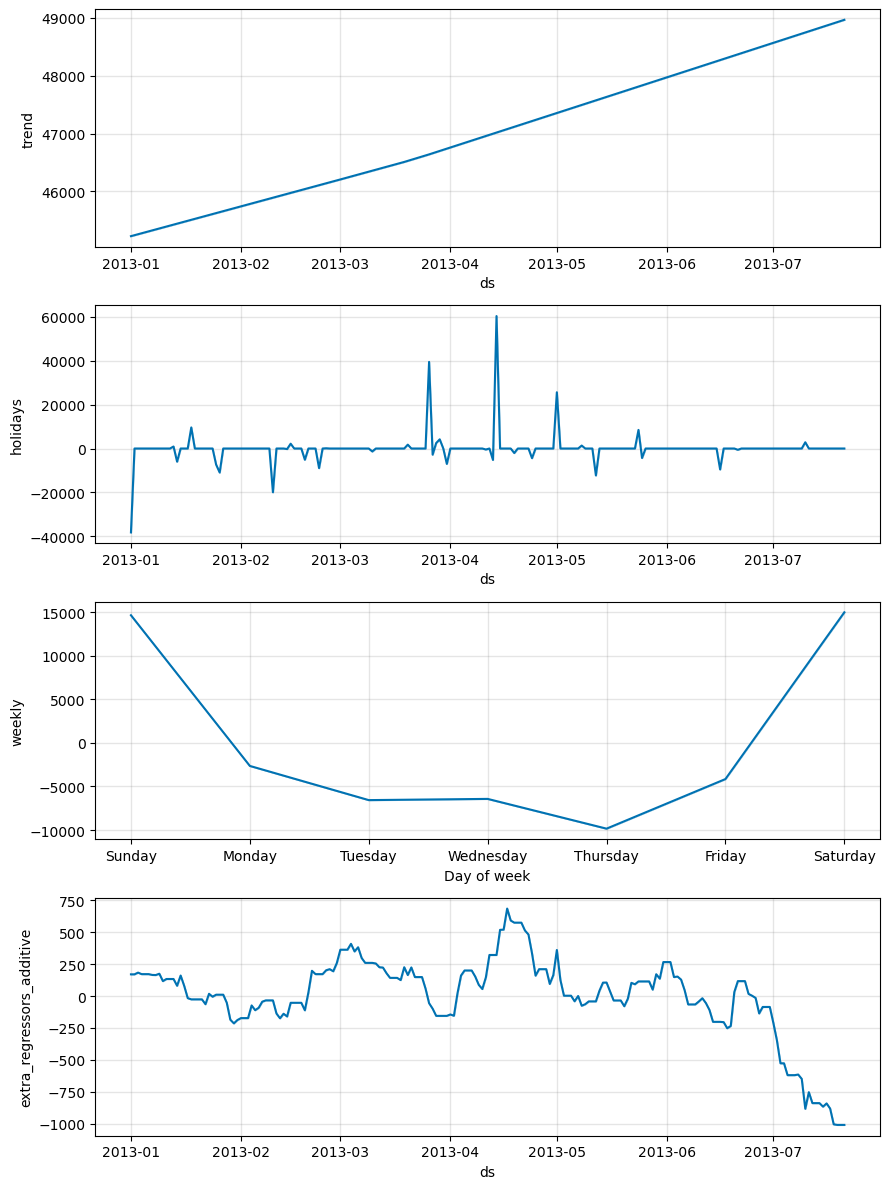

In [118]:
df=data
print(df.head())
df['dcoilwtico'].fillna(method='ffill', inplace=True)
df.at[0, 'dcoilwtico'] = 93.14

'''
rain = pd.read_csv('../data/weather/daily/commute/rain_day.csv', index_col=0, parse_dates=True)
rain = rain.loc[:,['Amount(mm)']]
rain.columns = ['rain']
rain.head()

data_with_regressors = utils.add_regressor(df, rain, varname='rain')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
'''

def sundays(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6:
        return 1
    else:
        return 0
df['sundays'] = df['ds'].apply(sundays)

data_train, data_test = prepare_data(df, 2017)

# Create and fit the model using training data

m = Prophet(holidays=df_holidays)

#m.add_regressor('sundays')
m.add_regressor('dcoilwtico')

m.fit(data_train)

future = m.make_future_dataframe(periods=len(data_test), freq='1D')
#futures = add_regressor_to_future(future, 'dcoilwtico')
#forecast = m.predict(future)
forecast = m.predict(data_train)
f = m.plot_components(forecast)

#fig = m.plot(forecast)
#fig = m.plot_components(forecast)

In [113]:
def prepare_data(data, year=2017): 

        
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

def add_regressor(data, regressor, varname=None): 

    data_with_regressors = data.copy()
    
    data_with_regressors.loc[:,varname] = regressor.loc[:,varname]
    
    return data_with_regressors

def add_regressor_to_future(future, regressors_df): 
    
    futures = future.copy() 
    
    futures.index = pd.to_datetime(futures.ds)
    
    regressors = pd.concat(regressors_df, axis=1)
    
    futures = futures.merge(regressors, left_index=True, right_index=True)
    
    futures = futures.reset_index(drop = True)
    
    return futures